In [ ]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:

# Get ticker
aapl = yf.Ticker("AAPL")

# Annual financial statements
fin = aapl.financials.T.reset_index()
bs = aapl.balance_sheet.T.reset_index()

# Merge
df = pd.merge(
    fin[['index', 'Total Revenue', 'Gross Profit', 'Operating Income', 'Net Income']],
    bs[['index', 'Total Assets', 'Total Liabilities Net Minority Interest', 'Cash And Cash Equivalents']],
    on='index'
)

# Rename and clean
df = df.rename(columns={'index': 'Date'})
df = df.dropna()
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Date'] >= '2019-01-01']
df = df.sort_values('Date').reset_index(drop=True)

# Show
print(df)

        Date   Total Revenue    Gross Profit Operating Income     Net Income  \
0 2021-09-30  365817000000.0  152836000000.0   108949000000.0  94680000000.0   
1 2022-09-30  394328000000.0  170782000000.0   119437000000.0  99803000000.0   
2 2023-09-30  383285000000.0  169148000000.0   114301000000.0  96995000000.0   
3 2024-09-30  391035000000.0  180683000000.0   123216000000.0  93736000000.0   

     Total Assets Total Liabilities Net Minority Interest  \
0  351002000000.0                          287912000000.0   
1  352755000000.0                          302083000000.0   
2  352583000000.0                          290437000000.0   
3  364980000000.0                          308030000000.0   

  Cash And Cash Equivalents  
0             34940000000.0  
1             23646000000.0  
2             29965000000.0  
3             29943000000.0  


In [ ]:
df = df.dropna()
print("\n Cleaned Data Sample:")
print(df.head())


 Cleaned Data Sample:
        Date   Total Revenue    Gross Profit Operating Income     Net Income  \
0 2021-09-30  365817000000.0  152836000000.0   108949000000.0  94680000000.0   
1 2022-09-30  394328000000.0  170782000000.0   119437000000.0  99803000000.0   
2 2023-09-30  383285000000.0  169148000000.0   114301000000.0  96995000000.0   
3 2024-09-30  391035000000.0  180683000000.0   123216000000.0  93736000000.0   

     Total Assets Total Liabilities Net Minority Interest  \
0  351002000000.0                          287912000000.0   
1  352755000000.0                          302083000000.0   
2  352583000000.0                          290437000000.0   
3  364980000000.0                          308030000000.0   

  Cash And Cash Equivalents  
0             34940000000.0  
1             23646000000.0  
2             29965000000.0  
3             29943000000.0  


In [ ]:
# correlation Matrix
print("\n Correlation Matrix:")
corr_matrix = df.corr()
print(corr_matrix.round(2))


 Correlation Matrix:
                                         Date  Total Revenue  Gross Profit  \
Date                                     1.00           0.65          0.92   
Total Revenue                            0.65           1.00          0.89   
Gross Profit                             0.92           0.89          1.00   
Operating Income                         0.78           0.91          0.96   
Net Income                              -0.27           0.46          0.03   
Total Assets                             0.83           0.49          0.79   
Total Liabilities Net Minority Interest  0.66           0.82          0.86   
Cash And Cash Equivalents               -0.24          -0.88         -0.58   

                                         Operating Income  Net Income  \
Date                                                 0.78       -0.27   
Total Revenue                                        0.91        0.46   
Gross Profit                                         0.9

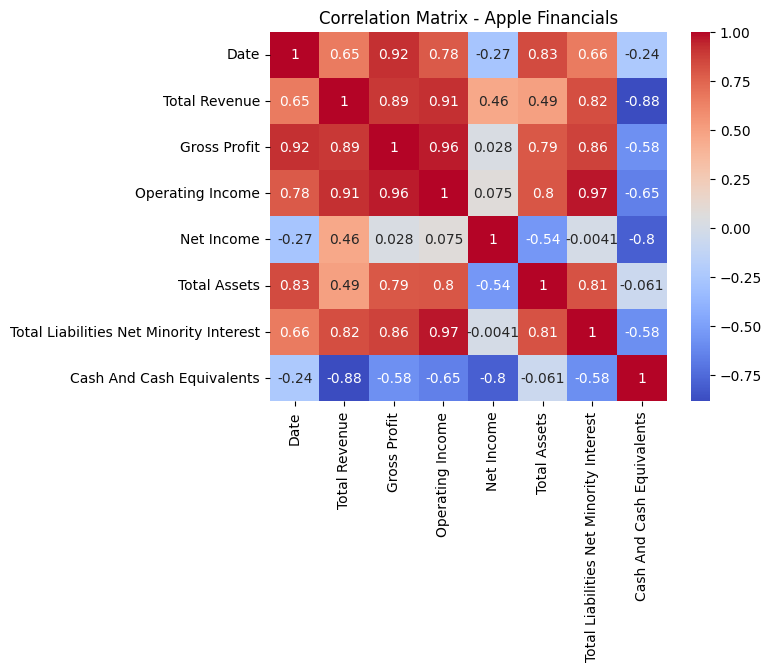

In [ ]:
# visual correlation heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix - Apple Financials")
plt.show()

In [ ]:
# To clean non-numeric values
X = df.copy()
X = X.apply(pd.to_numeric, errors='coerce')
X = X.replace([np.inf, -np.inf], np.nan).dropna()

# To compute VIF

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data.round(2))


                                   Feature  VIF
0                                     Date  inf
1                            Total Revenue  inf
2                             Gross Profit  inf
3                         Operating Income  inf
4                               Net Income  inf
5                             Total Assets  inf
6  Total Liabilities Net Minority Interest  inf
7                Cash And Cash Equivalents  inf


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [ ]:
# To compute only one of the collinear profit-related features
df_reduced = df.drop(columns=['Gross Profit', 'Operating Income'])

# To recompute VIF
X = df_reduced.apply(pd.to_numeric, errors='coerce')
X = X.replace([np.inf, -np.inf], np.nan).dropna()

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data.round(2))


                                   Feature  VIF
0                                     Date  inf
1                            Total Revenue  inf
2                               Net Income  inf
3                             Total Assets  inf
4  Total Liabilities Net Minority Interest  inf
5                Cash And Cash Equivalents  inf


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Handling with Ridge Regression

In [ ]:
# Handling Multicolinearity
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# To fetch Apple data
aapl = yf.Ticker("AAPL")
fin = aapl.quarterly_financials.T
bs = aapl.quarterly_balance_sheet.T

# To select only columns needed to avoid multicollinearity
df = pd.DataFrame({
    'Net Income': fin.get('Net Income'),
    'Total Assets': bs.get('Total Assets'),
    'Total Liabilities': bs.get('Total Liabilities Net Minority Interest'),
    'Cash': bs.get('Cash And Cash Equivalents')
}).dropna()

print(" Cleaned columns preview:")
print(df.head())


 Cleaned columns preview:
               Net Income    Total Assets Total Liabilities           Cash
2024-03-31  23636000000.0  337411000000.0    263217000000.0  32695000000.0
2024-06-30  21448000000.0  331612000000.0    264904000000.0  25565000000.0
2024-09-30  14736000000.0  364980000000.0    308030000000.0  29943000000.0
2024-12-31  36330000000.0  344085000000.0    277327000000.0  30299000000.0
2025-03-31  24780000000.0  331233000000.0    264437000000.0  28162000000.0


In [ ]:

# To Prepare predictors and target
X = df.drop(columns=['Net Income'])
y = df['Net Income']

# To standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# To Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Ridge Regr
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

print("\n Ridge Regression MSE (reduced features):", mean_squared_error(y_test, y_pred))
print("Ridge Coefficients (reduced features):", ridge.coef_)



 Ridge Regression MSE (reduced features): 2.8666793141248924e+20
Ridge Coefficients (reduced features): [-3.49590304e+09 -2.61416812e+09 -4.06009498e+09]


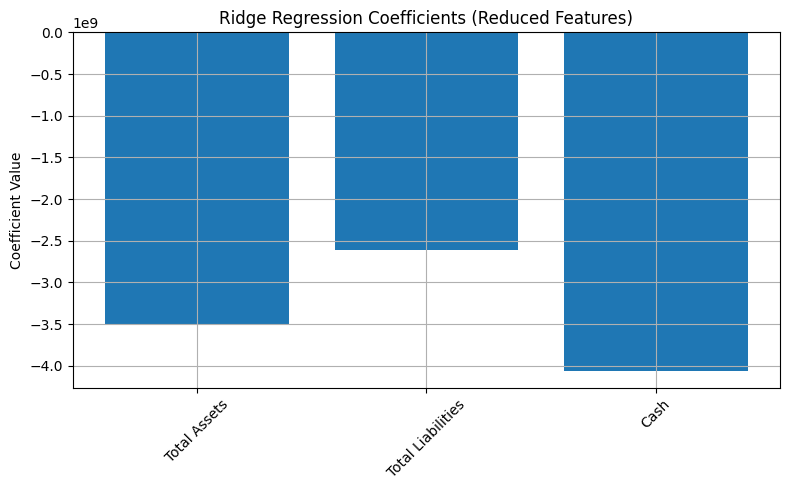

In [ ]:
# ToPlot coefs
plt.figure(figsize=(8,5))
plt.bar(X.columns, ridge.coef_)
plt.title("Ridge Regression Coefficients (Reduced Features)")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Handling with PCA


 Cumulative Explained Variance: [0.7   0.999 1.   ]


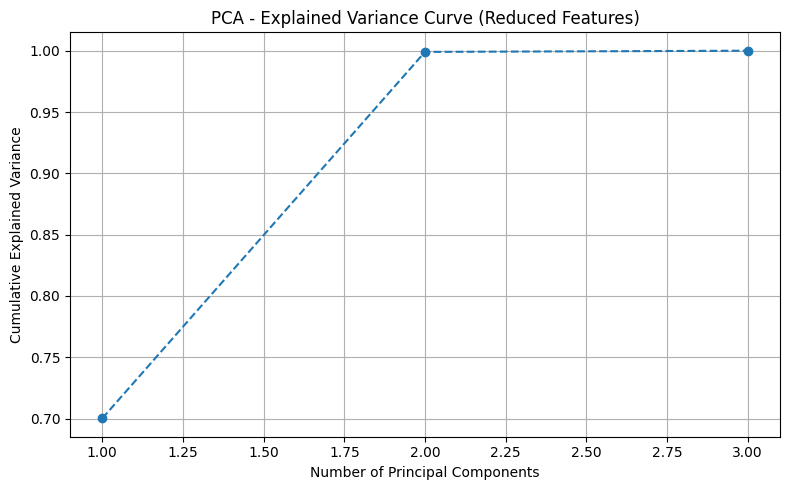


 Ridge Regression MSE on PCA components: 2.8666183839880764e+20


In [ ]:

from sklearn.decomposition import PCA
# To Prepare features and target
X = df.drop(columns=['Net Income'])
y = df['Net Income']

# To Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# To Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# To check cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)
print("\n Cumulative Explained Variance:", np.round(explained_variance, 3))

# To plot explained variance curve
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance Curve (Reduced Features)')
plt.grid(True)
plt.tight_layout()
plt.show()

# To usese first 2 principal components for regression
X_pca_selected = X_pca[:, :2]

# To split data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca_selected, y, test_size=0.3, random_state=42)

# Ridge Regresn on PCA feats
ridge_pca = Ridge(alpha=1.0)
ridge_pca.fit(X_train_pca, y_train_pca)
y_pred_pca = ridge_pca.predict(X_test_pca)

print("\n Ridge Regression MSE on PCA components:", mean_squared_error(y_test_pca, y_pred_pca))
